0. Notebook Setup & Imports

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import sqlite3

# Paths (adapt if yours differ)
project_root = Path("..")
db_path = project_root / "db" / "roku_telemetry.db"

conn = sqlite3.connect(db_path)

def q(sql: str) -> pd.DataFrame:
    return pd.read_sql_query(sql, conn)

# Load base tables
firmware_releases = q("SELECT * FROM firmware_releases;")
device_events = q("SELECT * FROM device_events;")

firmware_releases.head(), device_events.head()

(  firmware_version         release_date  \
 0           10.0.0  2024-01-01 00:00:00   
 1           10.0.5  2024-01-15 00:00:00   
 2           10.1.0  2024-01-31 00:00:00   
 3           10.1.2  2024-02-20 00:00:00   
 4           10.2.0  2024-03-10 00:00:00   
 
                                                notes  
 0                             Initial stable rollout  
 1       Minor bug fixes and performance improvements  
 2  Feature update - introduces potential activati...  
 3                     Hotfix for activation failures  
 4                                   Major UI refresh  ,
    event_id device_id error_code            timestamp firmware_version  \
 0         1     D0001       E402  2024-04-15 12:01:32           10.3.0   
 1         2     D0001       E204  2024-04-30 03:39:38           10.3.0   
 2         3     D0001       E102  2024-06-23 05:00:18           10.3.4   
 3         4     D0001       E102  2024-01-02 20:02:15           10.0.0   
 4         5     D0001

In [ ]:
2. Generate Synthetic Firmware Metadata

In [2]:
# --- Firmware metadata synthesis ---

# 1) Ensure release_date is datetime and sort chronologically
firmware_releases["release_date"] = pd.to_datetime(firmware_releases["release_date"])
fr = firmware_releases.sort_values("release_date").reset_index(drop=True)

# 2) Previous version + days since previous release
fr["previous_version"] = fr["firmware_version"].shift(1)
fr["days_since_previous_release"] = (
    fr["release_date"] - fr["release_date"].shift(1)
).dt.days

# For the very first release, avoid NaNs / divide-by-zero later
fr.loc[0, "days_since_previous_release"] = np.nan  # keep as NaN for now

# 3) Patch type (categorical)
rng = np.random.default_rng(seed=42)

patch_types = ["bugfix", "feature", "security", "hotfix"]
patch_probs = [0.60, 0.20, 0.10, 0.10]  # sums to 1.0

fr["patch_type"] = rng.choice(patch_types, size=len(fr), p=patch_probs)

# 4) Patch size (MB) with correlation to patch_type
base_sizes = rng.uniform(10, 250, size=len(fr))

size_multipliers = {
    "bugfix": 0.8,
    "feature": 1.2,
    "security": 1.0,
    "hotfix": 0.9,
}

fr["patch_size_mb"] = [
    base_sizes[i] * size_multipliers[pt] for i, pt in enumerate(fr["patch_type"])
]

# 5) Files changed ~ Poisson correlated with patch_size_mb
# Rough heuristic: larger patches touch more files
lambda_files = np.clip(fr["patch_size_mb"] / 8.0, 1, None)
fr["files_changed"] = rng.poisson(lam=lambda_files).astype(int)
fr.loc[fr["files_changed"] < 1, "files_changed"] = 1  # at least 1

# 6) Lines changed ~ Normal correlated with files_changed
# Roughly 50 lines per file on average, with noise
lines_mean = fr["files_changed"] * 50
lines_std = np.sqrt(fr["files_changed"]) * 30  # more files => more variance

lines_changed = rng.normal(lines_mean, lines_std)
lines_changed = np.clip(lines_changed, 0, None)  # no negatives
fr["lines_changed"] = lines_changed.round().astype(int)

# 7) is_hotfix flag (strongly tied to patch_type)
fr["is_hotfix"] = (fr["patch_type"] == "hotfix").astype(int)

# 8) Code churn score = lines_changed / days_since_prev + files_changed
# Avoid divide-by-zero by treating very small gaps as 1 day
days = fr["days_since_previous_release"].fillna(fr["days_since_previous_release"].median())
days = days.clip(lower=1)

fr["code_churn_score"] = fr["lines_changed"] / days + fr["files_changed"]

# 9) Keep just the synthetic metadata columns + keys
firmware_metadata = fr[
    [
        "firmware_version",
        "release_date",
        "previous_version",
        "days_since_previous_release",
        "patch_type",
        "patch_size_mb",
        "files_changed",
        "lines_changed",
        "is_hotfix",
        "code_churn_score",
    ]
].copy()

firmware_metadata

,firmware_version,release_date,previous_version,days_since_previous_release,patch_type,patch_size_mb,files_changed,lines_changed,is_hotfix,code_churn_score
0,10.0.0,2024-01-01,None,NaN,feature,141.711150,22,1310,0,92.810811
1,10.0.5,2024-01-15,10.0.0,14.0,bugfix,79.193221,12,510,0,48.428571
2,10.1.0,2024-01-31,10.0.5,16.0,security,232.423597,27,1501,0,120.812500
3,10.1.2,2024-02-20,10.1.0,20.0,feature,197.433155,20,774,0,58.700000
4,10.2.0,2024-03-10,10.1.2,19.0,bugfix,165.970230,20,955,0,70.263158
5,10.2.3,2024-03-28,10.2.0,18.0,hotfix,104.777467,15,769,1,57.722222
6,10.3.0,2024-04-15,10.2.3,18.0,feature,77.444752,10,556,0,40.888889
7,10.3.2,2024-05-05,10.3.0,20.0,feature,171.720419,26,1409,0,96.450000
8,10.3.4,2024-05-25,10.3.2,20.0,bugfix,20.252913,4,248,0,16.400000


In [3]:
# Save to CSV and SQLite for later use
firmware_metadata.to_csv(project_root / "data" / "firmware_metadata.csv", index=False)

firmware_metadata.to_sql(
    "firmware_metadata", conn, if_exists="replace", index=False
)
conn.commit()

In [4]:
# --- Device inventory synthesis ---

# 1) One row per device_id with real model/region
device_base = (
    device_events.sort_values("timestamp")
    .groupby("device_id")
    .agg(
        model=("model", "first"),
        region=("region", "first"),
    )
    .reset_index()
)

device_base.head()

,device_id,model,region
0,D0001,RokuTV-32,US
1,D0002,RokuStick-4K,US
2,D0003,RokuTV-43,MX
3,D0004,RokuSoundbar,US
4,D0005,RokuUltra,US


In [5]:
# Convert timestamp + get earliest firmware release date
device_events["timestamp"] = pd.to_datetime(device_events["timestamp"])
earliest_release = firmware_releases["release_date"].min()

n_devices = len(device_base)
rng = np.random.default_rng(seed=123)

# 2) manufacture_date: up to 5 years before earliest_release
max_age_days = 5 * 365
rand_offsets = rng.integers(0, max_age_days, size=n_devices)
manufacture_dates = earliest_release - pd.to_timedelta(rand_offsets, unit="D")
device_base["manufacture_date"] = manufacture_dates

# 3) hardware_revision correlated with age (older => more A)
# Normalize age: 0 (newest) to 1 (oldest)
age_days = (earliest_release - device_base["manufacture_date"]).dt.days
age_norm = (age_days - age_days.min()) / (age_days.max() - age_days.min() + 1e-6)

revisions = []
for a in age_norm:
    # Older devices: high prob of A, some B, few C
    if a > 0.66:
        probs = [0.7, 0.25, 0.05]
    elif a > 0.33:
        probs = [0.4, 0.4, 0.2]
    else:
        # Newer devices: more B/C
        probs = [0.15, 0.45, 0.4]
    revisions.append(rng.choice(["A", "B", "C"], p=probs))

device_base["hardware_revision"] = revisions

# 4) cpu_class correlated with model (rough heuristic by sorted order)
models_sorted = sorted(device_base["model"].unique())
n_models = len(models_sorted)

# First 1/3 low, middle 1/3 mid, last 1/3 high
low_cut = n_models // 3
high_cut = 2 * n_models // 3

model_to_cpu = {}
for i, m in enumerate(models_sorted):
    if i < low_cut:
        model_to_cpu[m] = "low"
    elif i < high_cut:
        model_to_cpu[m] = "mid"
    else:
        model_to_cpu[m] = "high"

device_base["cpu_class"] = device_base["model"].map(model_to_cpu)

# 5) device_age_days is derived later at event time, so we DON'T store it yet
device_inventory = device_base.copy()

device_inventory.head()

,device_id,model,region,manufacture_date,hardware_revision,cpu_class
0,D0001,RokuTV-32,US,2023-12-04,C,mid
1,D0002,RokuStick-4K,US,2020-08-04,A,mid
2,D0003,RokuTV-43,MX,2021-01-14,C,high
3,D0004,RokuSoundbar,US,2023-09-25,C,low
4,D0005,RokuUltra,US,2019-06-17,A,high


In [6]:
device_inventory.to_csv(project_root / "data" / "device_inventory.csv", index=False)

device_inventory.to_sql(
    "device_inventory", conn, if_exists="replace", index=False
)
conn.commit()

In [7]:
# --- ML feature table skeleton ---

# 1) Error rates per firmware (what you used in Tableau)
error_rates = pd.read_csv(project_root / "data" / "error_rates.csv")
# ensure firmware_version col name matches
error_rates.rename(
    columns={"firmware_version": "firmware_version"}, inplace=True
)

# 2) Join firmware_releases + metadata + error_rates
features = (
    firmware_metadata
    .merge(error_rates, on="firmware_version", how="left")
)

# 3) previous_version_error_rate lag feature
prev_map = error_rates.set_index("firmware_version")["error_rate_per_10k"]
features["previous_version_error_rate"] = features["previous_version"].map(prev_map)

features.head()

,firmware_version,release_date,previous_version,days_since_previous_release,patch_type,patch_size_mb,files_changed,lines_changed,is_hotfix,code_churn_score,error_events,error_rate_per_10k,previous_version_error_rate
0,10.0.0,2024-01-01,None,NaN,feature,141.711150,22,1310,0,92.810811,1993,19930.0,NaN
1,10.0.5,2024-01-15,10.0.0,14.0,bugfix,79.193221,12,510,0,48.428571,2186,21860.0,19930.0
2,10.1.0,2024-01-31,10.0.5,16.0,security,232.423597,27,1501,0,120.812500,2773,27730.0,21860.0
3,10.1.2,2024-02-20,10.1.0,20.0,feature,197.433155,20,774,0,58.700000,2550,25500.0,27730.0
4,10.2.0,2024-03-10,10.1.2,19.0,bugfix,165.970230,20,955,0,70.263158,2462,24620.0,25500.0


In [8]:
# --- Compute avg device age at time of upgrade ---

# 1) Convert timestamp to datetime
device_events["timestamp"] = pd.to_datetime(device_events["timestamp"])

# 2) Join events with inventory to get manufacture_date
dev = device_events.merge(device_inventory, on="device_id", how="left")

# 3) Compute age for each event
dev["device_age_days"] = (dev["timestamp"] - dev["manufacture_date"]).dt.days
dev = dev[dev["device_age_days"] >= 0]  # sanity clean

# 4) Average device age for each firmware_version
avg_age = (
    dev.groupby("firmware_version")["device_age_days"]
    .mean()
    .reset_index()
)

avg_age.rename(columns={"device_age_days": "avg_device_age_days"}, inplace=True)

avg_age.head()

,firmware_version,avg_device_age_days
0,10.0.0,922.013046
1,10.0.5,919.733760
2,10.1.0,938.190408
3,10.1.2,963.680392
4,10.2.0,962.986596


In [9]:
features = (
    features
    .merge(avg_age, on="firmware_version", how="left")
)

In [10]:
features.head()

,firmware_version,release_date,previous_version,days_since_previous_release,patch_type,patch_size_mb,files_changed,lines_changed,is_hotfix,code_churn_score,error_events,error_rate_per_10k,previous_version_error_rate,avg_device_age_days
0,10.0.0,2024-01-01,None,NaN,feature,141.711150,22,1310,0,92.810811,1993,19930.0,NaN,922.013046
1,10.0.5,2024-01-15,10.0.0,14.0,bugfix,79.193221,12,510,0,48.428571,2186,21860.0,19930.0,919.733760
2,10.1.0,2024-01-31,10.0.5,16.0,security,232.423597,27,1501,0,120.812500,2773,27730.0,21860.0,938.190408
3,10.1.2,2024-02-20,10.1.0,20.0,feature,197.433155,20,774,0,58.700000,2550,25500.0,27730.0,963.680392
4,10.2.0,2024-03-10,10.1.2,19.0,bugfix,165.970230,20,955,0,70.263158,2462,24620.0,25500.0,962.986596


In [16]:
features["previous_version_error_rate"] = (
    features["previous_version_error_rate"]
        .fillna(features["previous_version_error_rate"].median())
)

features["days_since_previous_release"] = (
    features["days_since_previous_release"]
        .fillna(features["days_since_previous_release"].median())
)


In [18]:
features.columns.tolist()


['firmware_version',
 'release_date',
 'previous_version',
 'days_since_previous_release',
 'patch_size_mb',
 'files_changed',
 'lines_changed',
 'is_hotfix',
 'code_churn_score',
 'error_events',
 'error_rate_per_10k',
 'previous_version_error_rate',
 'avg_device_age_days',
 'patch_feature',
 'patch_hotfix',
 'patch_security']

In [21]:
# Rebuild the core dataset (adjust this to whatever your notebook had earlier)

df = features.copy()  # OR whatever your base dataset was called

In [23]:

from sklearn.model_selection import train_test_split

# 1) Define target and feature columns
target = "error_rate_per_10k"

feature_cols = [
    "patch_size_mb",
    "code_churn_score",
    "is_hotfix",
    "days_since_previous_release",
    "previous_version_error_rate",
    "avg_device_age_days",
]

X = features[feature_cols].copy()
y = features[target].copy()

# 2) Train / Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42
)

X_train.shape, X_test.shape

((6, 6), (3, 6))

In [24]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, PoissonRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error

# Helper to evaluate models
def evaluate_model(name, model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    metrics = {
        "model": name,
        "r2_train": r2_score(y_train, y_pred_train),
        "r2_test": r2_score(y_test, y_pred_test),
        "mae_train": mean_absolute_error(y_train, y_pred_train),
        "mae_test": mean_absolute_error(y_test, y_pred_test),
    }
    return model, metrics


results = []

# 1) Linear Regression (with scaling)
lin_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LinearRegression()),
])
lin_model, lin_metrics = evaluate_model("LinearRegression", lin_pipe, X_train, y_train, X_test, y_test)
results.append(lin_metrics)

# 2) Random Forest
rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=4,
    random_state=42
)
rf_model, rf_metrics = evaluate_model("RandomForest", rf, X_train, y_train, X_test, y_test)
results.append(rf_metrics)

# 3) Poisson Regression (optional but nice to try)
pois_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("model", PoissonRegressor(alpha=1.0, max_iter=1000)),
])
pois_model, pois_metrics = evaluate_model("PoissonRegressor", pois_pipe, X_train, y_train, X_test, y_test)
results.append(pois_metrics)

results

[{'model': 'LinearRegression',
  'r2_train': 1.0,
  'r2_test': -1386.1471073864427,
  'mae_train': 5.4569682106375694e-12,
  'mae_test': 59656.818428169296},
 {'model': 'RandomForest',
  'r2_train': 0.8744606571975332,
  'r2_test': -1.0914781977899919,
  'mae_train': 2559.4222222222215,
  'mae_test': 2389.422222222222},
 {'model': 'PoissonRegressor',
  'r2_train': 0.9999962162347055,
  'r2_test': -4991.126555219604,
  'mae_train': 16.688960198199613,
  'mae_test': 84895.79733684612}]

Matplotlib is building the font cache; this may take a moment.


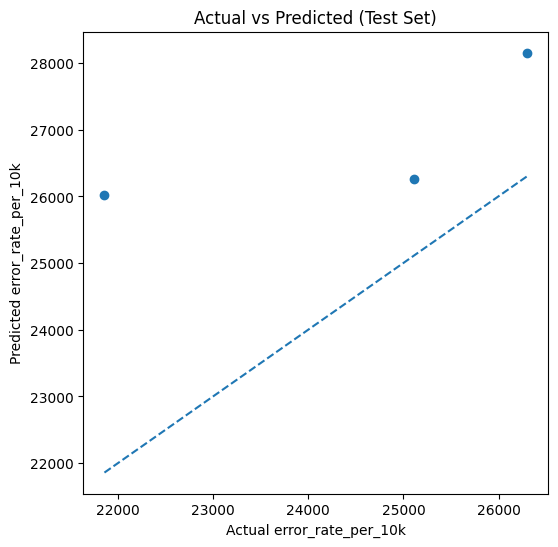

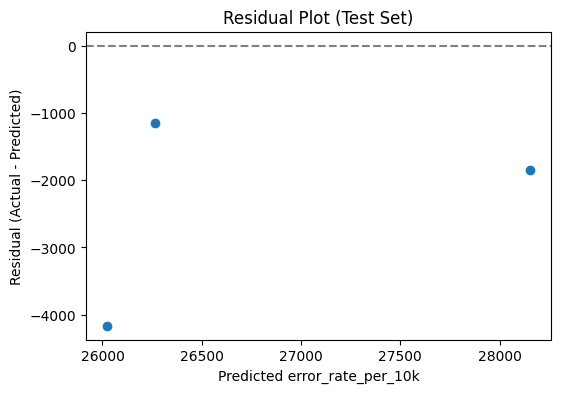

In [25]:
import matplotlib.pyplot as plt

best_model = rf_model  # or lin_model, pois_model

y_pred_test = best_model.predict(X_test)

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_test)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         linestyle="--")
plt.xlabel("Actual error_rate_per_10k")
plt.ylabel("Predicted error_rate_per_10k")
plt.title("Actual vs Predicted (Test Set)")
plt.show()

# Residual plot
residuals = y_test - y_pred_test

plt.figure(figsize=(6,4))
plt.scatter(y_pred_test, residuals)
plt.axhline(0, color="gray", linestyle="--")
plt.xlabel("Predicted error_rate_per_10k")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Residual Plot (Test Set)")
plt.show()

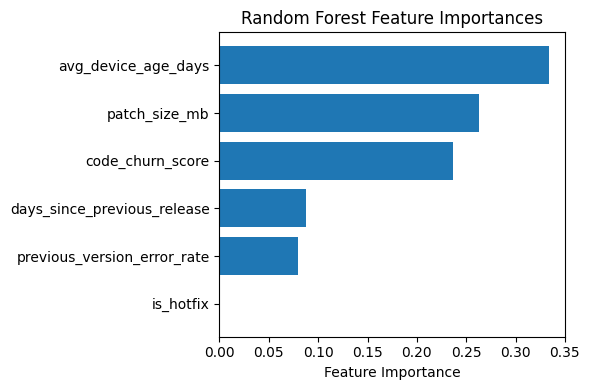

In [26]:
import numpy as np

importances = rf_model.feature_importances_
idx = np.argsort(importances)

plt.figure(figsize=(6,4))
plt.barh(np.array(feature_cols)[idx], importances[idx])
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importances")
plt.tight_layout()
plt.show()

In [27]:
from sklearn.ensemble import GradientBoostingRegressor

In [30]:
from xgboost import XGBRegressor

In [32]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
import numpy as np

results = {}

# --------------------------
# 1. Linear Regression
# --------------------------
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_preds = lr.predict(X_test)

results['LinearRegression'] = {
    "RMSE": np.sqrt(mean_squared_error(y_test, lr_preds)),
    "R2": r2_score(y_test, lr_preds)
}

# --------------------------
# 2. Random Forest Regressor
# --------------------------
rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    random_state=42
)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)

results['RandomForest'] = {
    "RMSE": np.sqrt(mean_squared_error(y_test, rf_preds)),
    "R2": r2_score(y_test, rf_preds)
}

# --------------------------
# 3. Gradient Boosting Regressor
# --------------------------
gbr = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3,
    random_state=42
)
gbr.fit(X_train, y_train)
gbr_preds = gbr.predict(X_test)

results['GradientBoosting'] = {
    "RMSE": np.sqrt(mean_squared_error(y_test, gbr_preds)),
    "R2": r2_score(y_test, gbr_preds)
}

# --------------------------
# 4. XGBoost Regressor
# --------------------------
xgb = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.9,
    colsample_bytree=0.9,
    objective="reg:squarederror",
    random_state=42
)

xgb.fit(X_train, y_train)
xgb_preds = xgb.predict(X_test)

results['XGBoost'] = {
    "RMSE": np.sqrt(mean_squared_error(y_test, xgb_preds)),
    "R2": r2_score(y_test, xgb_preds)
}

results

{'LinearRegression': {'RMSE': np.float64(69890.18652835333),
  'R2': -1386.1471073864293},
 'RandomForest': {'RMSE': np.float64(2713.823570372825),
  'R2': -1.0914781977899919},
 'GradientBoosting': {'RMSE': np.float64(1919.8861402708762),
  'R2': -0.046745417624457275},
 'XGBoost': {'RMSE': np.float64(2428.804969516578), 'R2': -0.6752337237407258}}

In [33]:
from pathlib import Path

project_root = Path("..").resolve()  # adjust if your notebooks folder depth is different

features.to_csv(project_root / "data" / "firmware_features_ml.csv", index=False)

print("Saved:", project_root / "data" / "firmware_features_ml.csv")

Saved: /Users/hc/Documents/projects/roku-patch-stability-analytics/data/firmware_features_ml.csv
